# Import libraries

In [1]:
# Import libraries
import os
import pandas as pd
import json
import sacrebleu

# Set Paths

In [2]:
# Base path
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))

# Model Parameters
unsloth_model_name = 'unsloth/Llama-3.2-3B-Instruct-bnb-4bit'
company_name = 'meta'
model_name = unsloth_model_name.split('/')[1]

# Results path
results_path_file = os.path.join(base_path, 'results', company_name, model_name, 'merged_results.json')

# Print paths
print('Base path:', base_path)
print('Results path:', results_path_file)

Base path: /cs/student/msc/csml/2023/ngriessh/historical_mt
Results path: /cs/student/msc/csml/2023/ngriessh/historical_mt/results/meta/Llama-3.2-3B-Instruct-bnb-4bit/merged_results.json


# Set Evaluation Parameters

In [19]:
# Choose source language
source_language = "English"
target_language = "English" if source_language == "Early Modern Bohemian German" else "Early Modern Bohemian German"

# Evaluate finetuning and icl?
evaluate_icl = True
evaluate_finetuning = False

# Median splitting with regard to word count?
median_splitting = True

# Translation direction is defined depending on the chosen source language
translation_direction = "DE_to_EN" if source_language == "Early Modern Bohemian German" else "EN_to_DE"

# Print
print(f'Source Language: {source_language}')
print(f'Target Language: {target_language}')
print(f'Translation Direction: {translation_direction}')
print(f'Evaluate ICL: {evaluate_icl}')
print(f'Evaluate finetuning: {evaluate_finetuning}')
print(f'Median Splitting? {median_splitting}')

Source Language: English
Target Language: Early Modern Bohemian German
Translation Direction: EN_to_DE
Evaluate ICL: True
Evaluate finetuning: False
Median Splitting? True


# Load Results File

In [20]:
# Load the JSON file
with open(results_path_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Create a DataFrame based on the JSON file
merged_df = pd.DataFrame(data)

# Check Columns

In [21]:
# Check column names
merged_df.columns

Index(['Early Modern Bohemian German', 'English',
       'DE_to_EN_000_example_prompt', 'DE_to_EN_001_example_prompt',
       'DE_to_EN_002_example_prompt', 'DE_to_EN_004_example_prompt',
       'DE_to_EN_008_example_prompt', 'DE_to_EN_016_example_prompt',
       'DE_to_EN_032_example_prompt', 'DE_to_EN_064_example_prompt',
       'DE_to_EN_128_example_prompt', 'EN_to_DE_000_example_prompt',
       'EN_to_DE_001_example_prompt', 'EN_to_DE_002_example_prompt',
       'EN_to_DE_004_example_prompt', 'EN_to_DE_008_example_prompt',
       'EN_to_DE_016_example_prompt', 'EN_to_DE_032_example_prompt',
       'EN_to_DE_064_example_prompt', 'EN_to_DE_128_example_prompt'],
      dtype='object')

# Construct Candidate Columns

In [22]:
# Define a function to generate candidate columns based on the conditions
def construct_candidate_columns(translation_direction, evaluate_icl, evaluate_finetuning):
    shots = ['000', '001', '002', '004', '008', '016', '032', '064', '128']
    
    # Add shots columns
    if evaluate_icl:
        if translation_direction == 'DE_to_EN':
            candidate_columns = [f'DE_to_EN_{shot}_example_prompt' for shot in shots]
        elif translation_direction == 'EN_to_DE':
            candidate_columns = [f'EN_to_DE_{shot}_example_prompt' for shot in shots]
    
    # Add finetuning column
    if evaluate_finetuning:
        if evaluate_icl:
            candidate_columns.append(f'{translation_direction}_finetuning')
        else:
            candidate_columns = [f'{translation_direction}_finetuning']
    
    return candidate_columns

# You can now concatenate or use these columns as needed
candidate_columns = construct_candidate_columns(translation_direction, evaluate_icl, evaluate_finetuning)
candidate_columns

['EN_to_DE_000_example_prompt',
 'EN_to_DE_001_example_prompt',
 'EN_to_DE_002_example_prompt',
 'EN_to_DE_004_example_prompt',
 'EN_to_DE_008_example_prompt',
 'EN_to_DE_016_example_prompt',
 'EN_to_DE_032_example_prompt',
 'EN_to_DE_064_example_prompt',
 'EN_to_DE_128_example_prompt']

# Median Splitting

In [23]:
# Compute word count for the source_language column
source_language_word_count = f'{source_language}_word_count'
merged_df[source_language_word_count] = merged_df[source_language].apply(lambda x: len(str(x).split()))

# Compute the median word count
median_word_count = merged_df[source_language_word_count].median()

# Create merged_df_short and merged_df_long based on the median
merged_df_short = merged_df[merged_df[source_language_word_count] <= median_word_count]
merged_df_long = merged_df[merged_df[source_language_word_count] > median_word_count]

#vPrint the shapes of the datasets
print("Shape of merged_df_short:", merged_df_short.shape)
print("Shape of merged_df_long:", merged_df_long.shape)
print(f'Median word count in {source_language}: {median_word_count}')

Shape of merged_df_short: (506, 21)
Shape of merged_df_long: (494, 21)
Median word count in English: 80.0


In [24]:
merged_df_short.head()

,Early Modern Bohemian German,English,DE_to_EN_000_example_prompt,DE_to_EN_001_example_prompt,DE_to_EN_002_example_prompt,DE_to_EN_004_example_prompt,DE_to_EN_008_example_prompt,DE_to_EN_016_example_prompt,DE_to_EN_032_example_prompt,DE_to_EN_064_example_prompt,...,EN_to_DE_000_example_prompt,EN_to_DE_001_example_prompt,EN_to_DE_002_example_prompt,EN_to_DE_004_example_prompt,EN_to_DE_008_example_prompt,EN_to_DE_016_example_prompt,EN_to_DE_032_example_prompt,EN_to_DE_064_example_prompt,EN_to_DE_128_example_prompt,English_word_count
2,3. Novembris. Matz Apelt beschweret sich Vber ...,3. Novembris. Matz Apelt complains against Jac...,November. Matz Apelt complains about Jacob Sch...,November. Mathias Apelt complains about Jacob ...,"The complainant, Matz Apelt, complains about J...",November. Matz Apelt complains about Jacob Sch...,The 3rd of November. Matz Apelt complains agai...,"On 3 November, Matz Apelt complains about Jaco...","On 3 November, Matz Apelt complains against Ja...",3. Novembris. Matz Apelt complains against Jac...,...,Dreizehnter November. Matz Apelt klagt gegen J...,Dreys Ember Maii. Matz Apelt klagt wider Jacob...,Dreynembris. Matz Apelt klagt gegen Jacoeb Sch...,Dreissigste November. Matz Apelt klagt gegen J...,Drei Novembres. Matz Apelt klaget gegen Jacobi...,Dem 3. Novembris. Matz Apelt klaget gegen Jacc...,Dem 3. Novemb. Matz Apelt klaget gegen Jaccho ...,"Matz Apelt klaget Jacob Schwedtner, weil er si...",Demnach Matz Apelt Zu Friedlandt Klaget gegen ...,77
3,"Adam Kötter von d. Wittige, demnach er sich mi...","Adam Koetter from the Wittige, since he disput...","Adam Kötter von der Witte, according to whom h...","The village headman of Wittige, according to w...","Adam Kötter from Wittige, since he has been im...","Adam Kötter from Wittige, since he has quarrel...","The village headman of Wittige, since he had q...","Adam Kötter from Wittige, since he had with Ur...","Adam Kötter from the witty, since he with Ursu...","Adam Kötter from the Wittige, since he quarrel...",...,"Adam Koetter von dem Wittigen, weil er in Wort...","Der Schultheß zu Witte, hat Adam Kötter von de...","Adam Koetter von der Wittige, demnach er in Wo...","Adam Koetter von Wittig, demnach er mit Ursula...","Adam Koetter von Wittige, demnach er mit Worte...","Dem Adam Koettert Zu Wittig, da er in Worten s...","Demnach Adam Koetter Zu Wittig, weil er mit Wo...","Adam Koetter Von der Wittige hat angelobt, das...","Adam Koetter Von der Wittige, demnach er mit U...",67
4,Adam Krauß zumb Einsiedel saget auff sein gewi...,Adam Krauss in Einsiedel declares on his consc...,"Adam Krauß says on his oath that he has sworn,...","Adam Krauß says on his oath, I will do it upon...","Adam Krauß to Einsiedel says, upon his oath, t...",Adam Krauß says to his wife about what has hap...,"Adam Krauß says on his oath, that he wishes to...","Adam Krauß says on his oath, that he wishes to...","Adam Krauß says on his oath, that he wishes to...","Adam Krauß says to his confession, that he int...",...,Adam Krauß in Einsiedl spricht auf seiner Gewi...,Adam Krauß zu Einsiedl spricht auf seiner Gewi...,Adam Krauß in Einsiedel bekennt sich auf sein ...,"Adam Krauß in Einsiedel, auf seiner Gewissen d...","Adam Krauß in Einsiedel, auf seiner Gewissheit...","Dem Adam Krauss in Einsiedel, auf seiner Gewis...","Dem Adam Krauss in Einsiedel, auf seiner Gewis...",Adam Krauss in Einsiedel klagt auf seiner Gewi...,Adam Krauss in Einsiedel beclagt auf seiner Ge...,70
10,Demnach Ihme vom Ampt Aufferleget vnd befohlen...,After he was instructed and commanded by the m...,"According to his office, he was ordered to eit...","According to him, having been appointed to thi...",According to his office and has been ordered t...,"According to the office, he has been ordered t...","To the office, it has been ordered that he sho...",To the office appointed to him and ordered to ...,Since he was ordered to perform his duties and...,"To the manorial court of Friedlandt, I have be...",...,N

In [25]:
merged_df_long.head()

,Early Modern Bohemian German,English,DE_to_EN_000_example_prompt,DE_to_EN_001_example_prompt,DE_to_EN_002_example_prompt,DE_to_EN_004_example_prompt,DE_to_EN_008_example_prompt,DE_to_EN_016_example_prompt,DE_to_EN_032_example_prompt,DE_to_EN_064_example_prompt,...,EN_to_DE_000_example_prompt,EN_to_DE_001_example_prompt,EN_to_DE_002_example_prompt,EN_to_DE_004_example_prompt,EN_to_DE_008_example_prompt,EN_to_DE_016_example_prompt,EN_to_DE_032_example_prompt,EN_to_DE_064_example_prompt,EN_to_DE_128_example_prompt,English_word_count
0,1. dz Sie verschienen freytag als den 29 huig ...,"1. last Friday, the 29th, they came up to the ...",They arrived on the 29th day in great haste to...,"The village headman of Friedland, named Hans N...",They appeared free on the 29th day of high in ...,They arrived freely on the 29th of high day at...,They arrived freely on the 29th of high day in...,They arrived freely on the 29th of high in gre...,They arrived freely on the 29th of high in gre...,They arrived freely on the 29th of high in gre...,...,"1. Am letzten Freitag, dem 29sten, kamen sie z...","Der Schulteß Zu Friedland, kam zu dem Burhause...","1. Gestern Freitag, der 29ten, kamen sie in gr...","1. Gestern Freitag, den 29ten, kamen sie in gr...","Von Freitag, den 29. Maien, kamen sie in große...","Dem Tagt Friddays, den 29. Octobris, kamen sie...","Dem Tagelichsten Freitag, den 29. September, k...",Der Herrscher Zu Friedlandt kam am letzten Fre...,Demnach sie alle zu dem Schloss Fridland in gr...,435
1,Es ist Vor.12. iharen Vnnd mehr Zu Oberweigßdo...,"12 years ago and more, in Oberweigsdorf, Paul ...",It is before the 12th of April in Oberweigßdor...,It is before the 12th of January and more to O...,It is before the 12th of January and more to O...,It is reported. 12 years ago and more To Oberw...,It is before the 12th of their own and more to...,"It is known that Paul Appelt, deceased in Ober...","It is reported that Paul Apelt, deceased in Ob...","It is reported that Paul Apelt, who has been d...",...,Zwölfig Jahre und mehr zuvor in Oberweigsdorf ...,Zwey jahre und mehr zuvor in Oberrhegisdorf is...,"Twelff Jahre vorher und mehr in Obergerwitz, i...",Twelff Jahre und mehr in Oberweygsdorf ist Pau...,"Twelff Jahre und mehr, in Obergerwiesdorff, Pa...",Vor 12 jaren und mehr in Obergerweigsdorf ist ...,Vier Jahre und mehr Vorher in Oberschleißheim ...,12 jahre und mehr Vorher in Oberweigsdorff sta...,Der alte Paul Apelt in Oberweigsdorff ist 12 j...,105
5,Raspenaw. Adam Kulman Klagt Vber Paul Kelern V...,Adam Kulman complains against Paul Kelern from...,Adam Kulman complains about Paul Keller from M...,"The village headman of Raspenaw, Adam Kulman c...",Plaintiff Adam Kulman complains against Paul K...,Adam Kulman complains about Paul Kelern from M...,Plaintiff Adam Kulman sues Paul Kelern von Mil...,Adam Kulman complains against Paul Keller from...,Adam Kulman complains against Paul Keller from...,Adam Kulman complains against Paul Kelern from...,...,"Kulman klägt gegen Paul Kelern von Mildenaich,...","Der Schultheß zu Miltenay, hat Hans Nicht und ...",Adam Kulman klagt gegen Paul Kelern von Milden...,Adam Kulman kläget gegen Paul Kelern von Milde...,"Die Vonn Maxen bringen Vor, wie vor wenig Woch...",Adam Kulman klagt gegen Paul Kelern von Milden...,Adam Kulman klaget gegen Paul Keler von Milden...,Christoff Flick Fleischer alhier Zu Friedlandt...,Christoff Nicht in Raspenau hat gegen Paul Kel...,443
6,Adam Seeliger Zu Mildenaich Claget Vber des al...,Adam Seeliger in Mildenaich complains against ...,Adam Seeliger of Mildenhall took from the late...,The village headman of Mildenaich names Adam S...,"Adam Seeliger To Mildenhain, claimed over the ...",Adam Seeliger To Mildenaich complains about th...,"The von Maxes bring forward, how a few weeks a...",Adam Seeliger of Mildenaich sues his son-in-la...,Adam Seeliger of Mildenaich sues over the late...,Adam Seeliger from Mildenaich complains that h...,...,Adam Seeliger in Mildenaich klägt g

# BLEU Evaluation

In [26]:
# Check if median splitting is true
if median_splitting:
    dataset_splits = [merged_df_short, merged_df_long]
    dataset_names = ['merged_df_short', 'merged_df_long']
else:
    dataset_splits = [merged_df]
    dataset_names = ['merged_df']

# Compute BLEU scores for both datasets
for split, name in zip(dataset_splits, dataset_names):
    # Print statement
    print('______________________________________________________________________________________________')
    print(f'Current Dataset: {name}. Source language is {source_language}.')
    print('______________________________________________________________________________________________')

    # Create references for split
    references = [split[target_language].tolist()]

    # Compute corpus-level BLEU scores
    for col in candidate_columns:
        candidates = split[col].tolist()
        print(f'Evaluation of target language {target_language} and LLM-generated candidates {col}')
        bleu_score = sacrebleu.corpus_bleu(candidates, references).score
        print(f"Corpus-level SacreBLEU score for {col}: {bleu_score:.3f}\n")

______________________________________________________________________________________________
Current Dataset: merged_df_short. Source language is English.
______________________________________________________________________________________________
Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_000_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_000_example_prompt: 2.170

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_001_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_001_example_prompt: 2.272

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_002_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_002_example_prompt: 3.340

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_004_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_004_example_prompt: 3.817

Evaluati

# Create Text File to Inspect Translation Results

In [30]:
# Function to generate the inspection text for a specific entry
def generate_inspection_text(df, entry_index, translation_directions, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:

        # Get the row corresponding to the entry index
        row = df.iloc[entry_index]

        # Write the German and English translations pairs by Sheilagh Ogilvie
        f.write(f"Entry {entry_index + 1}:\n")
        f.write(f"Early Modern Bohemian German (Sheilagh Ogilvie's Transcription): {row['Early Modern Bohemian German']}\n")
        f.write(f"English (Sheilagh Ogilvie): {row['English']}\n\n")

        # Write the candidate translations for each translation direction
        for col in df.columns:
            if any(direction in col for direction in translation_directions):
                f.write(f"{col}: {row[col]}\n")
        
        f.write("\n" + "="*50 + "\n\n")

# Define the translation directions and the entry to inspect
translation_directions = ['DE_to_EN', 'EN_to_DE']
entry_index = 0

# Call the function to generate the text file
output_file = 'translation_inspection_entry.txt'
generate_inspection_text(merged_df, entry_index, translation_directions, output_file)
print(f"Text file created: {output_file}")


Text file created: translation_inspection_entry.txt


In [31]:
candidates = ['hello how are you doing']
references = [['hello how are you doing hello how are you doing hello how are you doing hello how are you doing hello how are you doing']]

In [21]:
merged_df.columns

Index(['Early Modern Bohemian German', 'English', 'DE_to_EN_finetuning',
       'EN_to_DE_finetuning', 'English_word_count'],
      dtype='object')

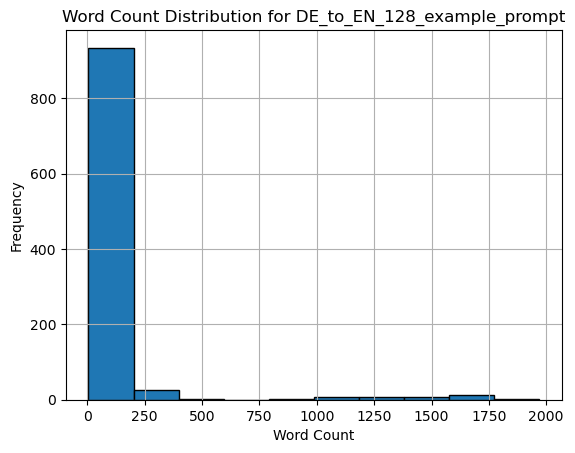

In [95]:
import matplotlib.pyplot as plt

# Function to compute word count and plot the histogram for any column
def plot_word_count_distribution(df, column_name):
    # Compute word count for each entry in the specified column
    df['word_count'] = df[column_name].apply(lambda x: len(x.split()))
    
    # Plotting the histogram of word count distribution
    plt.hist(df['word_count'], bins=10, edgecolor='black')
    plt.title(f'Word Count Distribution for {column_name}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'DE_to_EN_128_example_prompt')

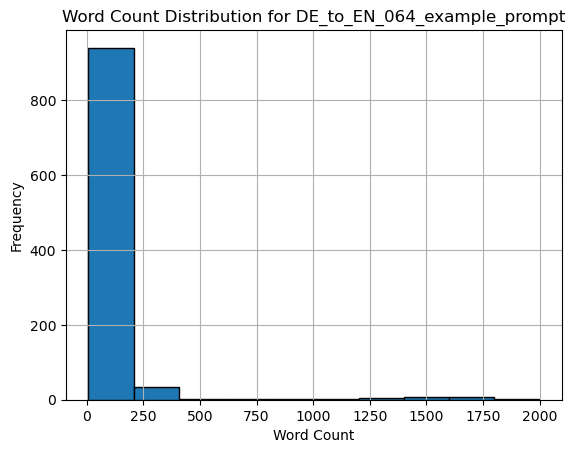

In [96]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'DE_to_EN_064_example_prompt')

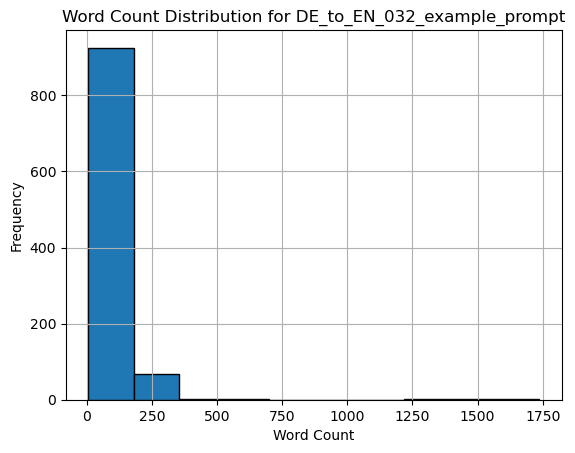

In [111]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'DE_to_EN_032_example_prompt')

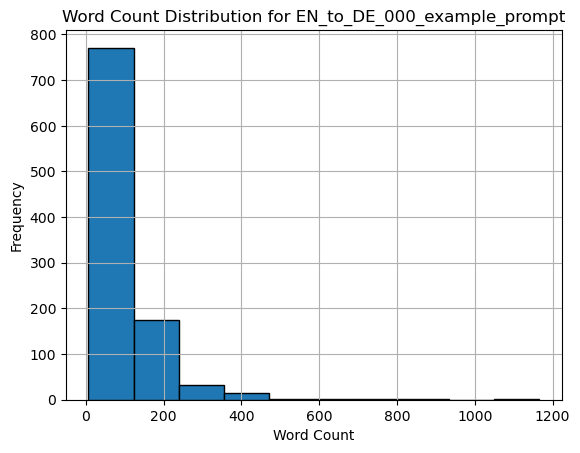

In [118]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_000_example_prompt')

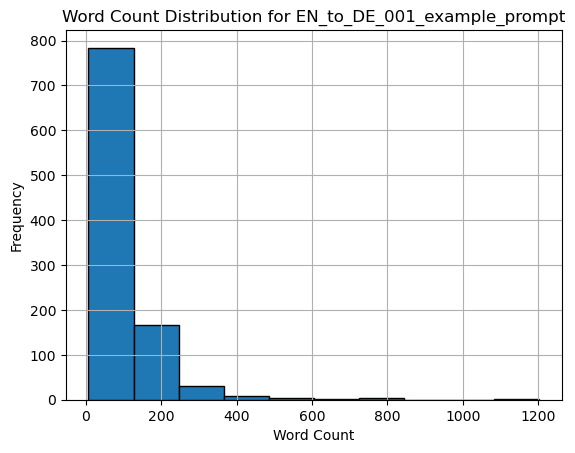

In [119]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_001_example_prompt')

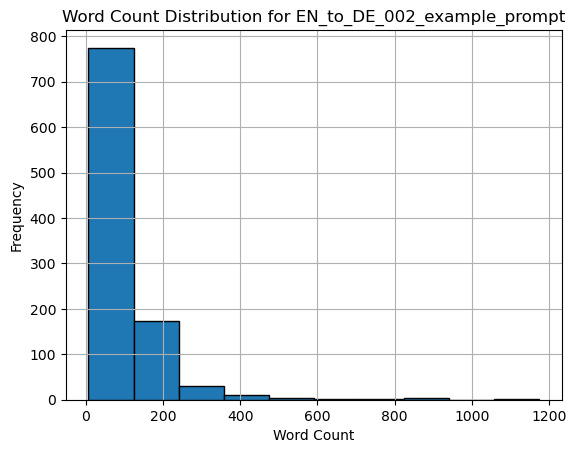

In [120]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_002_example_prompt')

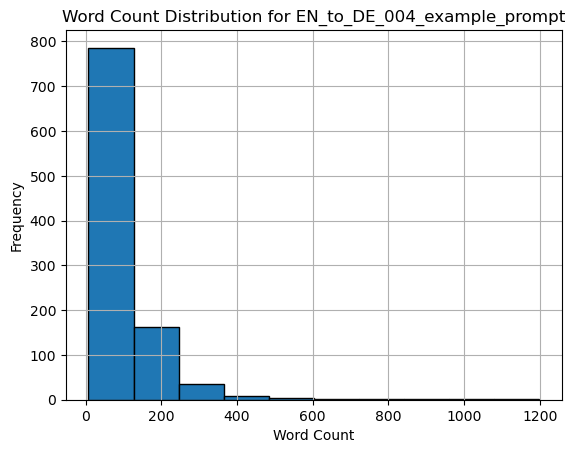

In [121]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_004_example_prompt')

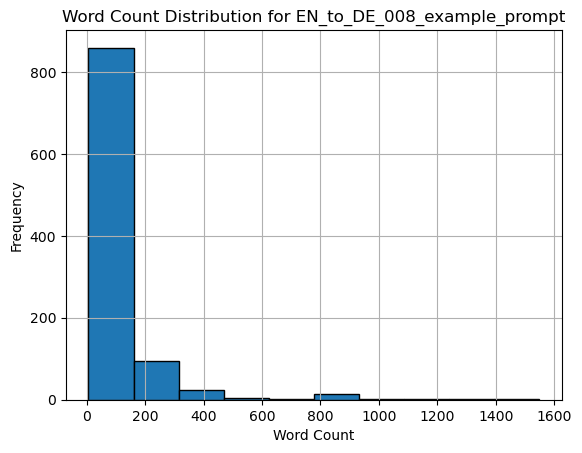

In [122]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_008_example_prompt')

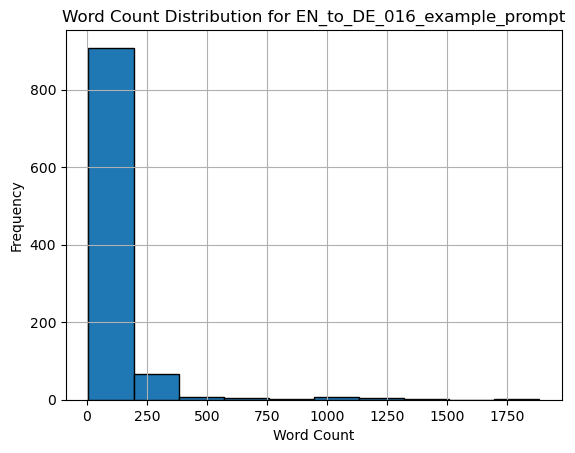

In [123]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_016_example_prompt')

/tmp/ipykernel_212106/3887351859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df[column_name].apply(lambda x: len(x.split()))


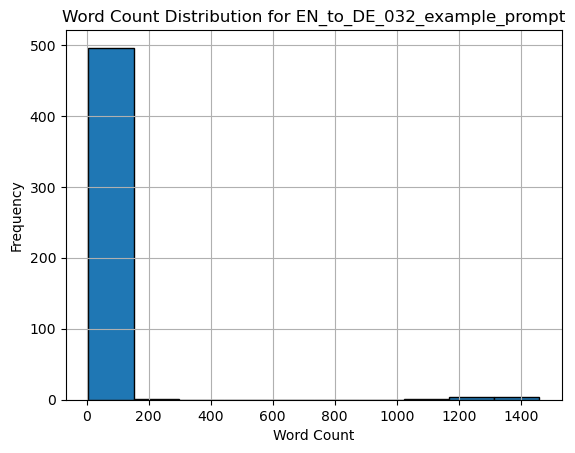

In [133]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df_short, 'EN_to_DE_032_example_prompt')

In [125]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_064_example_prompt')

KeyError: 'EN_to_DE_064_example_prompt'

In [ ]:
# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'EN_to_DE_128_example_prompt')

In [134]:
merged_df.columns

Index(['Early Modern Bohemian German', 'English',
       'DE_to_EN_000_example_prompt', 'DE_to_EN_001_example_prompt',
       'DE_to_EN_002_example_prompt', 'DE_to_EN_004_example_prompt',
       'DE_to_EN_008_example_prompt', 'DE_to_EN_016_example_prompt',
       'DE_to_EN_032_example_prompt', 'DE_to_EN_064_example_prompt',
       'DE_to_EN_128_example_prompt', 'EN_to_DE_000_example_prompt',
       'EN_to_DE_001_example_prompt', 'EN_to_DE_002_example_prompt',
       'EN_to_DE_004_example_prompt', 'EN_to_DE_008_example_prompt',
       'EN_to_DE_016_example_prompt', 'EN_to_DE_032_example_prompt',
       'English_word_count', 'word_count'],
      dtype='object')

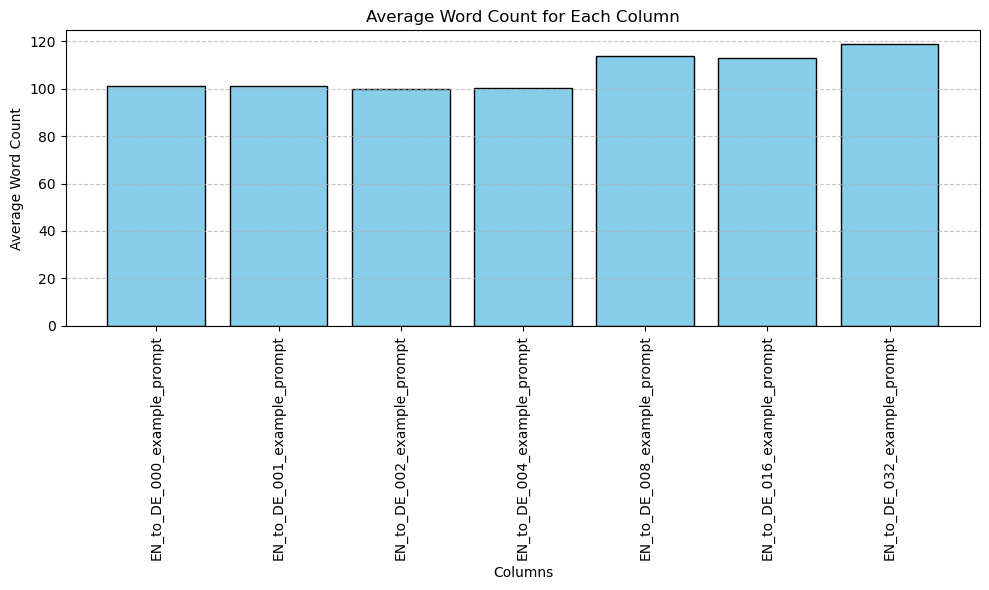

In [136]:
# Assuming df contains the columns mentioned by the user

# List of columns to compute the word count for
columns = ['DE_to_EN_000_example_prompt', 'DE_to_EN_001_example_prompt',
           'DE_to_EN_002_example_prompt', 'DE_to_EN_004_example_prompt',
           'DE_to_EN_008_example_prompt', 'DE_to_EN_016_example_prompt',
           'DE_to_EN_032_example_prompt', 'DE_to_EN_064_example_prompt',
           'DE_to_EN_128_example_prompt']

columns = ['EN_to_DE_000_example_prompt', 'EN_to_DE_001_example_prompt',
           'EN_to_DE_002_example_prompt', 'EN_to_DE_004_example_prompt', 'EN_to_DE_008_example_prompt',
           'EN_to_DE_016_example_prompt', 'EN_to_DE_032_example_prompt']


# Dictionary to store average word count for each column
avg_word_counts = {}

# Compute the average word count for each column
for col in columns:
    avg_word_counts[col] = merged_df[col].apply(lambda x: len(str(x).split())).mean()

# Convert the result into a DataFrame for easier plotting
avg_word_counts_df = pd.DataFrame(list(avg_word_counts.items()), columns=['Column', 'Average Word Count'])

# Plotting the average word count for each column
plt.figure(figsize=(10, 6))
plt.bar(avg_word_counts_df['Column'], avg_word_counts_df['Average Word Count'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Average Word Count for Each Column')
plt.xlabel('Columns')
plt.ylabel('Average Word Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
